In [1]:
from models import *
from utils import *
from dataset import *
# from torch.utils.data import DataLoader
# import pandas as pd
import numpy as np

/mnt/disk1/anaconda3/envs/anhnh/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/disk1/anaconda3/envs/anhnh/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


In [2]:
# device="cuda:1"
# model = VGGTransformer(config)
# model.load_state_dict(torch.load("/mnt/disk4/VN_HTR/VN_HTR/source/weights/cp_vgg_transformer_finetune_v4.pt", map_location="cuda:1"))
# model.to(device)
a_model = AdapterVGGTransformer(config)
a_model.load_state_dict(torch.load("/mnt/disk4/VN_HTR/VN_HTR/source/weights/finetune_adapter_vgg_transformer_v3.pt", map_location="cuda:1"))
a_model.to(device)
print("----------")

----------


In [3]:
def infer_topk(img, net, max_seq_length=128, sos_token=1, eos_token=2, backbone="vgg", adapter=False):
    "data: BxCXHxW"
    net.eval()
    device = img.device
    net.to(device)
    if not adapter:
        model = net
    else:
        model = net.basemodel
    device = img.device
    model.to(device)

    with torch.no_grad():
        src = model.backbone(img)
        
        memory = model.transformerLM.forward_encoder(src)
        if backbone != "vgg":
            memory = memory.transpose(1,0)
    
        translated_sentence = [[sos_token]*len(img)]
        probs = []
        tokens = []

        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T==eos_token, axis=1)):

            tgt_inp = torch.LongTensor(translated_sentence).to(device)
            
            output, memory = model.transformerLM.forward_decoder(tgt_inp, memory)
            if adapter:
                output = net.forward_adapt(output)
            output = F.softmax(output, dim=-1)
            output = output.to('cpu')

            values, indices  = torch.topk(output, 5)

            probs.append(values[0, -1].cpu().numpy())
            tokens.append(indices[0, -1].cpu().numpy())
            
            indices = indices[:, -1, 0]
            indices = indices.tolist()

            translated_sentence.append(indices)   
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T
    return translated_sentence, np.array(tokens).T, np.array(probs).T

In [4]:
tkz = Tokenizer(config)

def inference(net, img_path, device, adapter=False):
    img = Image.open(img_path)
    display(img)
    img, _ = process_input(img)
    with torch.no_grad():
        net.eval()
        # print(img.shape)
        # pred, tokens, probs = infer_topk(torch.FloatTensor(img).unsqueeze(0), net, backbone="vgg")
        return infer_topk(torch.FloatTensor(img).unsqueeze(0).to(device), net, backbone="vgg", adapter=adapter)
        # print(tkz.reverse_tokens_special(pred[0]))
        # for i in range(tokens.shape[0]):
        #     print(tokens[i])
        #     tmp = dict(zip(tkz.reverse_tokens_special(tokens[i]), probs[i]))
        #     print(tmp)
        #     print(len(tmp))

In [6]:
import pandas as pd
testdf = pd.read_csv("/mnt/disk4/VN_HTR/VN_HTR/test_anot.csv")
# 18, 56, 69

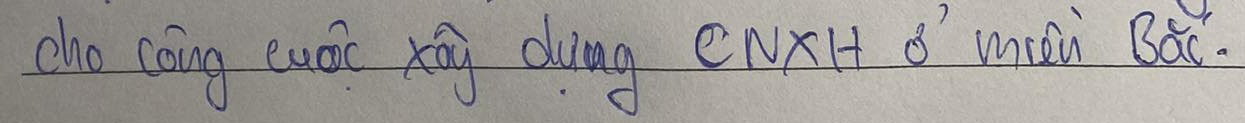

In [9]:
pred_18, tokens_18, probs_18 = inference(a_model, "/mnt/disk4/VN_HTR/VN_HTR/test/test17_test1.jpg", "cuda:1", True) #test17_test1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

weights = probs_18

# plt.figure(figsize = (64, 9))

fig, ax = plt.subplots(figsize=(20, 20))

# Create a custom colormap that transitions from white to 'viridis'
viridis_white = plt.cm.Blues(np.linspace(0, 1, 256))
viridis_white[:, :3] = 1 - (1 - viridis_white[:, :3]) * 0.7  # Adjust the brightness

# Create a LinearSegmentedColormap using the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', viridis_white)

# Set the normalization to map the weights to the range [0, 1]
norm = Normalize(vmin=0, vmax=1)

# Use the created colormap in imshow with the specified norm
cax = ax.imshow(weights, cmap=cmap, interpolation='none', norm=norm)

for i in range(tokens_18.shape[0]):
    text = tkz.reverse_tokens_special(tokens_18[i])
    for j in range(len(text)):
        char = text[j]
        if char == "<unk>": char = "#"
        if char == "<eos>": char = "/s"
        ax.text(j, i, char)
# ax.text(0, 0, "h")
# ax.text(1, 0, "e")
# ax.text(2, 0, "l")
# ax.text(3, 0, "l")
# ax.text(4, 0, "o")
# ax.text(5, 0, " ")
# ax.text(6, 0, "w")

# Add colorbar to display the color scale
cbar = plt.colorbar(cax)

plt.show()


In [ ]:

for i in range(40, 70):
    if testdf.iloc[i].filename[:4] == "wild":
        pred, tokens, probs = inference(model, f"/mnt/disk4/VN_HTR/VN_HTR/WildLine/{testdf.iloc[i].filename}", "cuda:0", False)
        print(tkz.reverse_tokens(pred[0]), end=f"    ---{i}---")
# a_pred, a_tokens, a_probs = inference(a_model, "/mnt/disk4/VN_HTR/VN_HTR/WildLine/wild_15_1158.jpg", "cuda:1", True)
# print(tkz.reverse_tokens(a_pred[0]))
# test17_test1.jpg, test1_test2.jpg, test3_test2

In [ ]:
import os
x = []
for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    pred, tokens, probs = inference(model, "/mnt/disk4/VN_HTR/VN_HTR/test/" + fn, "cuda:1", False)
    print(tkz.reverse_tokens(pred[0]), end=f"    ---{fn}---")
    x.append({"content": tkz.reverse_tokens(pred[0]), "fn": fn})
for i in x:
    print(i)

In [7]:
for i in x:
    print(i)

{'content': 'Heo nghị định số 111 NĐ ngày 5-1550 do', 'fn': 'test13_test1.jpg'}
{'content': 'nghệ có tạu sở đại Hà Nội, Việt Nan', 'fn': 'test2_test2.jpg'}
{'content': 'công nghệ, tác động quan trạng vào phát triển nền kinh', 'fn': 'test6_test1.jpg'}
{'content': 'cưa hàng đầu khu vực với nòng cốt là Kỹ truật và', 'fn': 'test5_test1.jpg'}
{'content': 'Ký, Đây là tường đại học Kỹ Huật đầu tiên của', 'fn': 'test15_test1.jpg'}
{'content': 'Viên của hiệp hôi các đạt học Kỹ thuật hàng đầu khu', 'fn': 'test10_test1.jpg'}
{'content': 'lập vào ngày 0 tháng săm 1555, Ngày 5', 'fn': 'test9_test2.jpg'}
{'content': 'Hà Nội taở thành đại học đa trành viên thố lo Củ VNN', 'fn': 'test3_test1.jpg'}
{'content': 'Q- TTg về việc chuyển Tang Đại học Bách Khoa Hà', 'fn': 'test1_test1.jpg'}
{'content': 'trong những đại học Kỹ Huật lớn nhất Vi,', 'fn': 'test4_test2.jpg'}
{'content': 'Việt Nam, Đại học Bách khoa Hà Nột cũng là thành', 'fn': 'test9_test1.jpg'}
{'content': 'tế tri thức và gốp phần gồn giữ on nin

In [8]:
for i in [{'content': 'Heo nghị định số 177 NĐ ngày 6355556 do', 'fn': 'test13_test1.jpg'}, {'content': 'nghệ có trụ sở tại Hà Nội, Việt Nan', 'fn': 'test2_test2.jpg'}, {'content': 'công nghệ, tác động quan trạng vào phát triển nền kinh', 'fn': 'test6_test1.jpg'}, {'content': 'cưa hàng đầu khu vực với nàng cốt là Kỹ thuột và', 'fn': 'test5_test1.jpg'}, {'content': 'Ký, Đầy là trường đại học Kỹ Huật đầu tiên của', 'fn': 'test15_test1.jpg'}, {'content': 'viên của hiệp hội các đại học Kỹ thuật hàng đầu khu', 'fn': 'test10_test1.jpg'}, {'content': 'lập vào ngày 6 tháng năm 105, Ngày 5', 'fn': 'test9_test2.jpg'}, {'content': 'Hà Nội trở thành đại học đa thành viên thố của VN', 'fn': 'test3_test1.jpg'}, {'content': 'Qu-Tg về việc chuyển Trường Đại học Bách Khoa Hà', 'fn': 'test1_test1.jpg'}, {'content': 'trong những đại học Kỹ thuật lớn nhốt V1', 'fn': 'test4_test2.jpg'}, {'content': 'Việt Nam, Đại học Bách Khoa Hà Nột cùng là thành', 'fn': 'test9_test1.jpg'}, {'content': 'tế tri thức và gốp phần gòn giữ on ninh, hoà tình', 'fn': 'test7_test1.jpg'}, {'content': 'là đại học theo lĩnh vực Kỹ thuật và công', 'fn': 'test1_test2.jpg'}, {'content': 'đốt nước, tiên phong trong hệ thống giác dục đại học', 'fn': 'test8_test1.jpg'}, {'content': 'tháng tệ năm 302, thư tướng Chính phả bon', 'fn': 'test10_test2.jpg'}, {'content': 'Tầm nhừa của đại học là trở thành mật đại học nghiên', 'fn': 'test4_test1.jpg'}, {'content': 'Đại học Bách khoa Hà Nội được xem là một', 'fn': 'test3_test2.jpg'}, {'content': 'Tiền thân của Đại học Bách Khoa Hà Nội rồn là', 'fn': 'test7_test2.jpg'}, {'content': 'Trường Đại học Bách Khoa Hà Nội được Hành', 'fn': 'test8_test2.jpg'}, {'content': 'bộ trưởng Bộ giáo dực Việt Nặm Nguyễn Văn Hyên', 'fn': 'test14_test1.jpg'}, {'content': 'Việt Nam có nhiệm vạ dào tạo Kỹ sư công nghiệp', 'fn': 'test16_test1.jpg'}, {'content': 'Đại học Bách Khoa Hà Nội CBKHNH', 'fn': 'test0_test2.jpg'}, {'content': 'trục Huộc Bộ Giáo dục và Đào tạo và được', 'fn': 'test5_test2.jpg'}, {'content': 'Xếp vào nhóm các đại học trạng điển Qu', 'fn': 'test6_test2.jpg'}, {'content': 'vực châu Á Thái Bình Dương,', 'fn': 'test11_test1.jpg'}, {'content': 'Thơ tướng Chính phủ ban hành Quyết đạnh số 1312', 'fn': 'test0_test1.jpg'}, {'content': 'cho công cuộc xây dựng CNXH ở miền Bắc', 'fn': 'test17_test1.jpg'}, {'content': 'Nội thành Đại hạc Bách Khoa Hà Nội, đựa Bách Khoa', 'fn': 'test2_test1.jpg'}, {'content': 'Trường Đại học Bách Khoa Hà Nội được thành lộp', 'fn': 'test12_test1.jpg'}]:
    print(i)

{'content': 'Heo nghị định số 177 NĐ ngày 6355556 do', 'fn': 'test13_test1.jpg'}
{'content': 'nghệ có trụ sở tại Hà Nội, Việt Nan', 'fn': 'test2_test2.jpg'}
{'content': 'công nghệ, tác động quan trạng vào phát triển nền kinh', 'fn': 'test6_test1.jpg'}
{'content': 'cưa hàng đầu khu vực với nàng cốt là Kỹ thuột và', 'fn': 'test5_test1.jpg'}
{'content': 'Ký, Đầy là trường đại học Kỹ Huật đầu tiên của', 'fn': 'test15_test1.jpg'}
{'content': 'viên của hiệp hội các đại học Kỹ thuật hàng đầu khu', 'fn': 'test10_test1.jpg'}
{'content': 'lập vào ngày 6 tháng năm 105, Ngày 5', 'fn': 'test9_test2.jpg'}
{'content': 'Hà Nội trở thành đại học đa thành viên thố của VN', 'fn': 'test3_test1.jpg'}
{'content': 'Qu-Tg về việc chuyển Trường Đại học Bách Khoa Hà', 'fn': 'test1_test1.jpg'}
{'content': 'trong những đại học Kỹ thuật lớn nhốt V1', 'fn': 'test4_test2.jpg'}
{'content': 'Việt Nam, Đại học Bách Khoa Hà Nột cùng là thành', 'fn': 'test9_test1.jpg'}
{'content': 'tế tri thức và gốp phần gòn giữ on ninh

In [ ]:
import os
x = []
for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    pred, tokens, probs = inference(a_model, "/mnt/disk4/VN_HTR/VN_HTR/test/" + fn, "cuda:1", True)
    print(tkz.reverse_tokens(pred[0]), end=f"    ---{fn}---")
    x.append({"content": tkz.reverse_tokens(pred[0]), "fn": fn})
print(x)

In [ ]:
for i in range(40, 70):
    if testdf.iloc[i].filename[:4] == "wild":
        pred, tokens, probs = inference(a_model, f"/mnt/disk4/VN_HTR/VN_HTR/WildLine/{testdf.iloc[i].filename}", "cuda:1", True)
        print(tkz.reverse_tokens(pred[0]), end=f"    ---{i}---")
# a_pred, a_tokens, a_probs = inference(a_model, "/mnt/disk4/VN_HTR/VN_HTR/WildLine/wild_15_1158.jpg", "cuda:1", True)
# print(tkz.reverse_tokens(a_pred[0]))

In [ ]:
import os

for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    pred, tokens, probs = inference(a_model, "/mnt/disk4/VN_HTR/VN_HTR/test/" + fn, "cuda:1", True)
    print(tkz.reverse_tokens(pred[0]), end=f"    ---{fn}---")

In [53]:
for i in range(tokens.shape[0]):
    tmp = tuple(zip(tkz.reverse_tokens_special(tokens[i]), probs[i].round(4)))
    print(tmp)

(('t', 0.9273), ('r', 0.9321), ('ự', 0.9219), ('c', 0.9244), (' ', 0.9058), ('t', 0.5622), ('h', 0.9277), ('u', 0.9411), ('ộ', 0.9401), ('c', 0.9287), (' ', 0.9017), ('B', 0.935), ('ộ', 0.9329), (' ', 0.9049), ('G', 0.9367), ('i', 0.9261), ('á', 0.9324), ('o', 0.9322), (' ', 0.9053), ('d', 0.9338), ('ụ', 0.9382), ('c', 0.9104), (' ', 0.9013), ('v', 0.9324), ('à', 0.9286), (' ', 0.9093), ('Đ', 0.9297), ('à', 0.9376), ('o', 0.9332), (' ', 0.9006), ('t', 0.9293), ('ạ', 0.9362), ('o', 0.9303), (' ', 0.9007), ('v', 0.9348), ('ò', 0.8326), (' ', 0.9054), ('d', 0.4924), ('ư', 0.5767), ('ợ', 0.8471), ('c', 0.9288), ('<eos>', 0.9269))
(('T', 0.0008), ('h', 0.0005), ('ụ', 0.002), ('n', 0.0005), ('.', 0.0009), ('H', 0.16), ('r', 0.0065), ('ư', 0.0013), ('ậ', 0.0008), ('i', 0.0007), ('.', 0.0007), ('3', 0.0016), ('ô', 0.0006), ('.', 0.0006), ('g', 0.0007), ('I', 0.0004), ('a', 0.0011), ('c', 0.0006), ('.', 0.0007), ('đ', 0.001), ('ạ', 0.0007), (' ', 0.0038), ('.', 0.0007), ('V', 0.0008), ('ã', 0.0

In [36]:
for i in range(tokens.shape[0]):
    tmp = dict(zip(tkz.reverse_tokens_special(tokens[i]), probs[i]))
    print(tmp)

{'t': 0.92571366, 'r': 0.9301629, 'a': 0.6478406, 'n': 0.9210225, 'g': 0.92645246, ' ': 0.90226066, 'h': 0.92294353, 'ữ': 0.91769713, 'đ': 0.9278551, 'ạ': 0.93222916, 'i': 0.9247812, 'ọ': 0.93643177, 'c': 0.9253971, 'K': 0.15403917, 'ỹ': 0.812234, 'u': 0.930903, 'ậ': 0.9341998, 'l': 0.93081135, 'ớ': 0.9374189, 'ấ': 0.9359826, 'I': 0.3761612, '1': 0.2790362, '<eos>': 0.38782385}
{'T': 0.00051482, 'l': 0.00047659088, 'o': 0.17405069, 'm': 0.00054043904, '9': 0.0005243499, '.': 0.00073801255, '8': 0.0004026902, 'ĩ': 0.0019817445, ' ': 0.00041094297, 'Đ': 0.0005512231, 'a': 0.0005076578, 'ị': 0.00045593875, 'H': 0.00043908137, 'ụ': 0.0006446788, 'C': 0.00045120576, 'k': 0.003099342, 'ẽ': 0.008122525, 'ư': 0.0006500538, 'â': 0.000547395, 'n': 0.00063682056, 'L': 0.0005911664, 'ơ': 0.0007772768, 'ẩ': 0.00061181193, 'V': 0.07340679, '1': 0.090377204, 'I': 0.21604463}
{'+': 0.00044764418, 's': 0.00046208242, 'u': 0.0028193642, 'c': 0.00043736654, 'h': 0.0005001601, 'n': 0.0005014891, ' ': 0.00

In [4]:
tkz = Tokenizer(config)

def inference(net, img_path):
    img = Image.open(img_path)
    display(img)
    # print(img.size)
    img, _ = process_input(img)
    with torch.no_grad():
        net.eval()
        # print(img.shape)
        # print(img)
        # pred, tokens, probs = infer_topk(torch.FloatTensor(img).unsqueeze(0), net, backbone="vgg")
        return infer_transformer_base(torch.FloatTensor(img).unsqueeze(0), net, backbone="vgg")
        # print(tkz.reverse_tokens_special(pred[0]))
        # for i in range(tokens.shape[0]):
        #     print(tokens[i])
        #     tmp = dict(zip(tkz.reverse_tokens_special(tokens[i]), probs[i]))
        #     print(tmp)
        #     print(len(tmp))

In [ ]:
import os
for fn in ["wild_0_0.jpg", "wild_19_1107.jpg", "wild_19_1138.jpg", "wild_0_1.jpg", "wild_1_1.jpg", "wild_2_1.jpg"]:
    print(tkz.reverse_tokens(inference(model, "/mnt/disk4/VN_HTR/VN_HTR/WildLine/" + fn)[0]))

In [ ]:
import os
for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    print(inference(model, "/mnt/disk4/VN_HTR/VN_HTR/test/" + fn))